# AI generated music challenge | Fraud detection

Because the organizers observed statistics that did not make any sense during the evaluation. Because we discovered at the end of the contest that the submissions were easily identifiable through a unique identifier. We decided to run this Fraud detection analysis. 

In this notebook is presented statistics demonstrating that votes made by several IP addresses were all in favor of only one or a few submissions. In addition, we show that these IP addresses are localized in well defined locations and always in favor of a group of participants. 

Votes made by these IP addresses are removed from the pool and the scores are computed according to the updated log. 



In [1]:
import json
import base64
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import cPickle
import pygeoip
GEOIP = pygeoip.GeoIP("GeoLiteCity.dat", pygeoip.MEMORY_CACHE)
import trueskill

/Users/Flo/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load the submissions IDs and create MIDI files

In [4]:
filekey = json.load(open("meta/submission_to_key_map.json"))
submission_ids = []
for key, val in filekey.items():
    print key, val
    submission_ids.append(str(key))
    data = json.load(open("submissions/"+val+"/submission.json"))
    midi = base64.standard_b64decode(data['dataUri'][23:])
    with open("submissions/"+key+".mid", "wb") as file:
        file.write(midi)

3713 7678bdc8-c326-413f-be95-1385c19b000c
3712 180ef882-5a5e-42b2-bf9e-1adfec5cb068
3590 8f052b97-1a4d-42ca-aec2-09bfca9c3c34
3656 3397f8df-27a6-45d8-baef-032dba0b522b
3615 bd1f98d3-7d83-48e5-a1dd-bc67139cf90a
3553 de2c7a56-96b7-431f-8309-be67f7fb10f8
3552 82391d76-8696-4382-815c-c466eafe239f
3594 2f5ff57b-948f-4ad4-8162-def942501008
3790 e225b913-d148-4c77-8e52-6286d98fb9a6
3793 ee56473b-6d16-4dad-b9db-b8643eb20f01
3857 a2f7f57e-4cd5-4c10-bb2f-118ee8dae8fb
3852 e9c0d78c-dd07-41c9-8e9a-462ccbf7fe13
3528 3cf08e7f-b77a-404e-9497-cfbab460b580
3763 880770ad-2033-4760-a021-7b7b50162850
3766 e4813eb8-678d-4430-944e-52d2a495f3cb
3768 dfc048ed-ce41-4038-90cb-1757b46067f5
3649 fa767547-1893-4f89-82f9-85ce5177e139
3647 a97118bb-0942-417b-87c5-226ce10c49f8
3646 0646ab08-7ac1-46fd-a9d5-d955c1b8fc6e
3645 fcd482d9-f5e6-43bc-be9a-9078b042433b
3644 dc58997b-1067-4dcf-aa3c-2bd4471ffde9
3642 ab389daa-4069-4b6c-bca1-7466c9abdfd3
3796 e0aeda8a-982b-4a8e-8268-8e517ea0101e
3560 c073da9e-a1a1-4fc2-8274-5bc56

# Load the LOG

In [74]:
with open('meta/LOGS.json') as data_file:
    df = data_file.read()
    data = json.loads(df)
decoder=json.decoder.JSONDecoder()
log = []
for d in data:
    log.append(decoder.decode(d))
print "Number of votes:", len(log)

controls = ['3532', '3530', '3552', '3553']
#Separate votes by IP addresses
logperaddr = {}
for l in log:
    if l['remote_addr'] in logperaddr.keys():
        logperaddr[l['remote_addr']].append(l)
    else:
        logperaddr[l['remote_addr']] = [l]
print 'Different IP addresses:', len(logperaddr)

Number of votes: 6900
Different IP addresses: 307


# Probability of win for each submission per IP addresses

104.196.231.176 Mountain View 43 3613
35.185.234.157 Mountain View 38 3613
35.227.25.23 Mountain View 56 3613
35.196.121.37 Mountain View 68 3613
35.197.95.251 Mountain View 114 3613
117.5.214.3 Hanoi 14 3613
171.229.170.246 Hanoi 9 3613
35.185.77.146 Mountain View 44 3613
104.196.43.182 Mountain View 82 3613
36.149.70.54 Suzhou 41 3790
35.203.156.221 Mountain View 26 3613
35.185.53.223 Mountain View 96 3613
171.229.246.93 Hanoi 4 3613
35.199.164.137 Mountain View 469 3613
35.227.174.66 Mountain View 104 3613
35.197.123.234 Mountain View 54 3613
104.196.165.181 Mountain View 54 3613
35.196.13.28 Mountain View 100 3613
35.185.241.158 Mountain View 23 3613
35.203.158.175 Mountain View 7 3613
35.197.126.179 Mountain View 38 3613
35.203.178.94 Mountain View 92 3613
35.185.6.248 Mountain View 67 3613
1643 0.238115942029 ['3613', '3790']


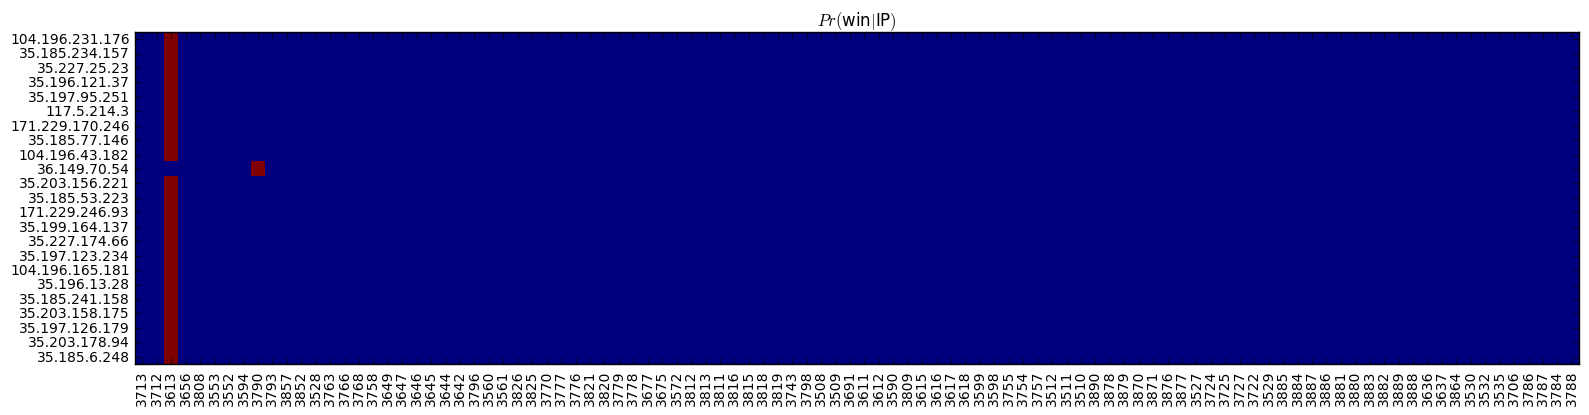

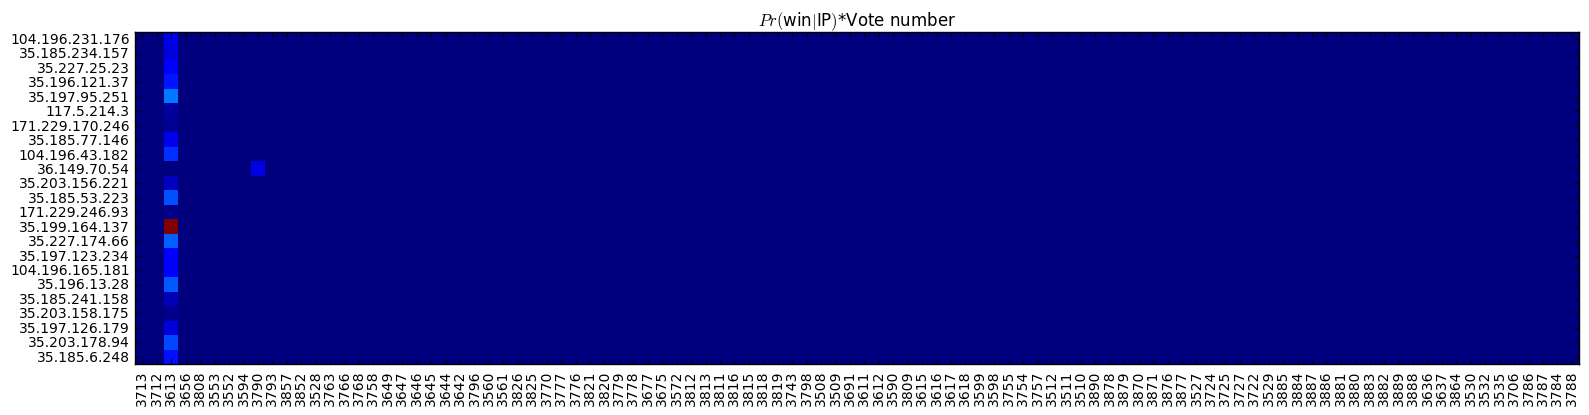

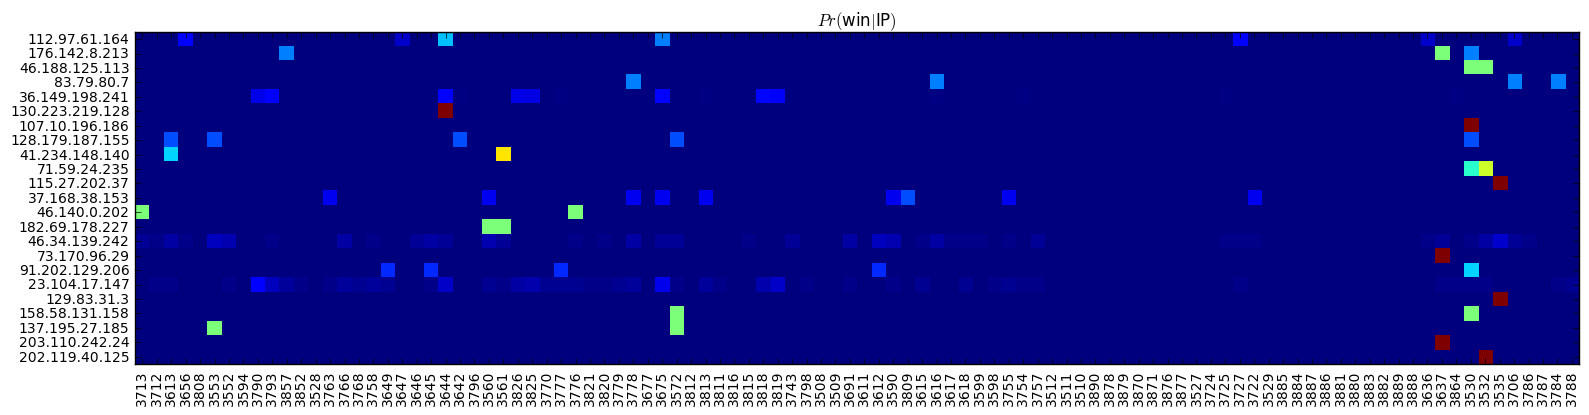

In [7]:
thres = 0.99

mat = []
mat2 = []
matcontrol = []
IPcontrol = []
cheaters = []
cheatersIPs = []
cheatnumber = 0
for key, val in logperaddr.items():
    hist = {}
    for subid in submission_ids:
        hist[subid] = 0
    for l in val:
        if l['winner'] == 1:
            winner = l['submission_2']
        else:
            winner = l['submission_1']
        hist[winner] += 1
    vec = [v for _, v in hist.items()]
    z = np.sum(vec)
    vec = [float(v)/z for v in vec]
    cheat = False
    for k,v in hist.items():
        hist[k] = v/z
        if hist[k] > thres:
            cheater_id = k
            cheat = True
    if cheat:
        if cheater_id in controls or len(val) < 4:
            cheat = False
    if cheat:
        cheatnumber += len(val)
        mat.append(vec)
        mat2.append(np.asarray(vec)*len(val))
        print key, GEOIP.record_by_addr(key)['city'], len(val), cheater_id
        
        #print vec
        cheatersIPs.append(key)
        cheaters.append(cheater_id)
    else:
        matcontrol.append(vec)
        IPcontrol.append(key)

cheaters = sorted(set(cheaters))
    
plt.figure(figsize=(16,16))
plt.title('$Pr($win$|$IP$)$')
plt.imshow(np.asarray(mat), interpolation='nearest')
xlabels = []
for k,v in hist.items():
    xlabels.append(k)
plt.xticks(range(len(xlabels)), xlabels, rotation='vertical')
plt.yticks(range(len(cheatersIPs)), cheatersIPs, rotation='horizontal')
plt.tight_layout()

plt.figure(figsize=(16,16))
plt.title('$Pr($win$|$IP$)$*Vote number')
plt.imshow(np.asarray(mat2), interpolation='nearest')
xlabels = []
for k,v in hist.items():
    xlabels.append(k)
plt.xticks(range(len(xlabels)), xlabels, rotation='vertical')
plt.yticks(range(len(cheatersIPs)), cheatersIPs, rotation='horizontal')
plt.tight_layout()

plt.figure(figsize=(16,16))
plt.title('$Pr($win$|$IP$)$')
idxes = np.random.randint(len(matcontrol),size=len(cheatersIPs))
plt.imshow(np.asarray(matcontrol)[idxes], interpolation='nearest')
xlabels = []
for k,v in hist.items():
    xlabels.append(k)
plt.yticks(range(len(cheatersIPs)), np.asarray(IPcontrol)[idxes], rotation='horizontal')
plt.xticks(range(len(xlabels)), xlabels, rotation='vertical')
plt.tight_layout()


print cheatnumber, float(cheatnumber)/len(log), cheaters

# Probability of win when submission S was a possible choice for each submission S per IP addresses

Fraudulent IP addresses exposed by human inspection of votes made by single IP addresses. For a submission to be classified as fraudulent it should match multiple criteria. The criteria include a too high number of positive only votes for a single submission or group of submissions belonging to the same (group of) user, the localization of the IP address, the results of control submissions and the quality of the submission. 

In [82]:
invalidIPs = [
            '129.70.149.192', 
            '23.104.209.6', 
            '183.40.151.207', 
            '131.173.254.165', 
            '35.185.6.248', 
            '123.114.5.155', 
            '35.203.178.94', 
            '23.104.212.18', 
            '35.197.126.179', 
            '35.203.158.175', 
            '121.32.167.87', 
            '36.149.198.241', 
              '35.185.241.158', 
              '121.32.166.247', 
              '36.110.66.106', 
              '23.104.213.5', 
              '35.196.13.28', 
              '104.196.165.181', 
              '141.58.16.28', 
              '23.104.17.147', 
              '141.58.17.208', 
              '14.25.63.175', 
              '74.222.20.27', 
              '118.70.129.253', 
              '35.197.123.234', 
              '35.227.174.66', 
              '23.104.17.155', 
              '35.199.164.137', 
              '120.239.78.180', 
              '119.136.154.66', 
              '36.149.70.21', 
              '120.230.70.166', 
              '119.136.153.97', 
              '141.58.16.43', 
              '131.173.253.191', 
              '171.229.246.93', 
              '35.185.53.223', 
              '112.97.61.164', 
              '35.203.156.221', 
              '36.149.70.54', 
              '104.196.43.182', 
              '35.185.77.146', 
              '171.229.170.246', 
              '117.5.214.3', 
              '170.178.162.100', 
              '104.196.231.176', 
              '141.58.16.93',  
              '23.104.209.6', 
              '121.32.167.233', 
              '35.185.234.157', 
              '23.104.17.91', 
              '129.70.128.172', 
              '36.149.198.119', 
              '121.32.166.35', 
              '141.58.17.53', 
              '74.222.20.19', 
              '35.227.25.23', 
              '170.178.178.164', 
              '183.63.51.77', 
              '35.196.121.37', 
              '121.32.164.142', 
              '35.197.95.251',
            '112.26.228.245'
]  


1 [SUSPECT]->[CHEAT] 170.178.162.100 Las Vegas US ['3793', '3644', '3675'] 356 66.3400716449
3713 (0.375, [1, 1, 0, 0, 1, 0, 0, 0])
3712 (0.20000000000000001, [0, 0, 1, 1, 0, 0, 0, 0, 0, 0])
3613 (0.0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
3656 (0.36363636363636365, [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])
3808 (0.0, [0, 0])
CONTROL 3553 (0.083333333333333329, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
CONTROL 3552 (0.25, [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])
3594 (0.27272727272727271, [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0])
3790 (1.0, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

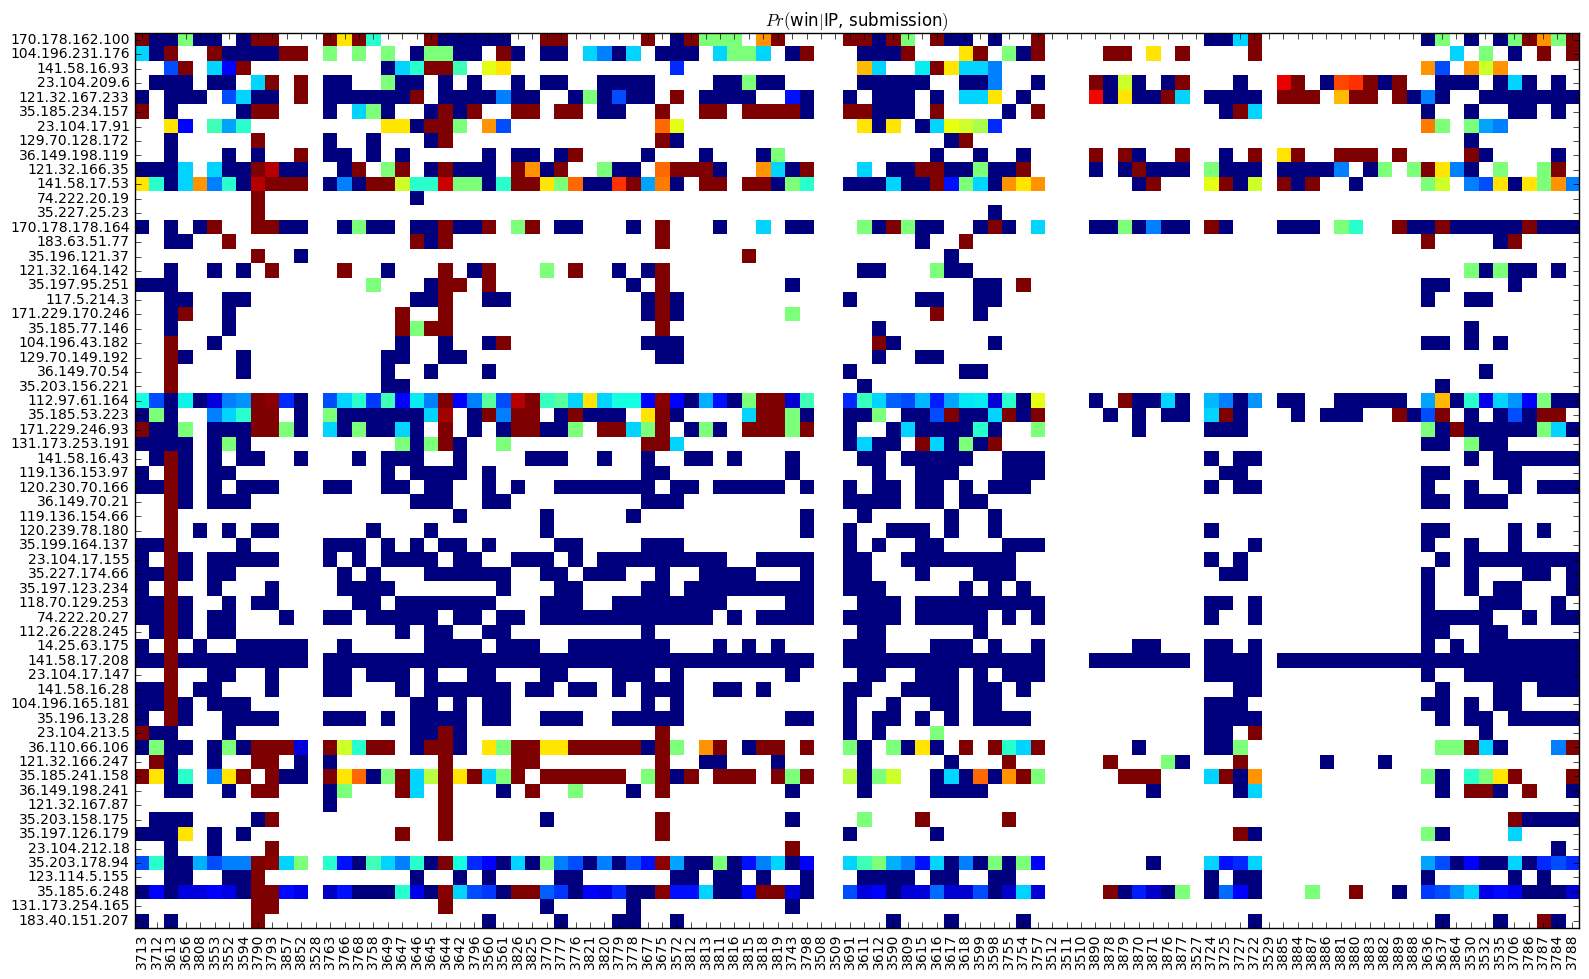

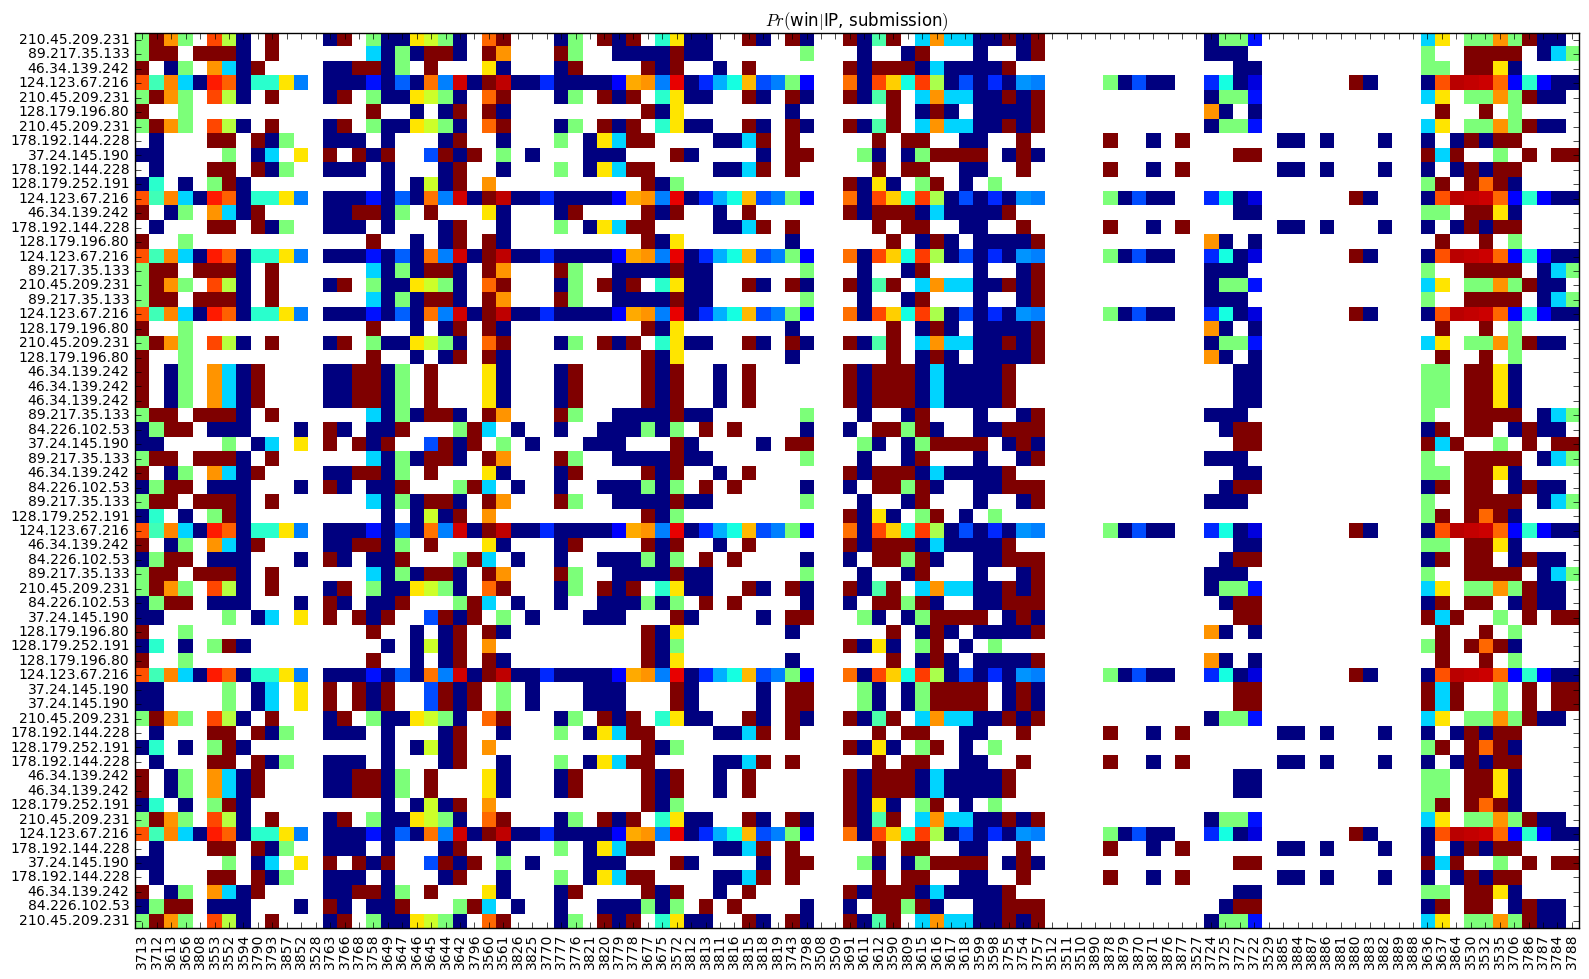

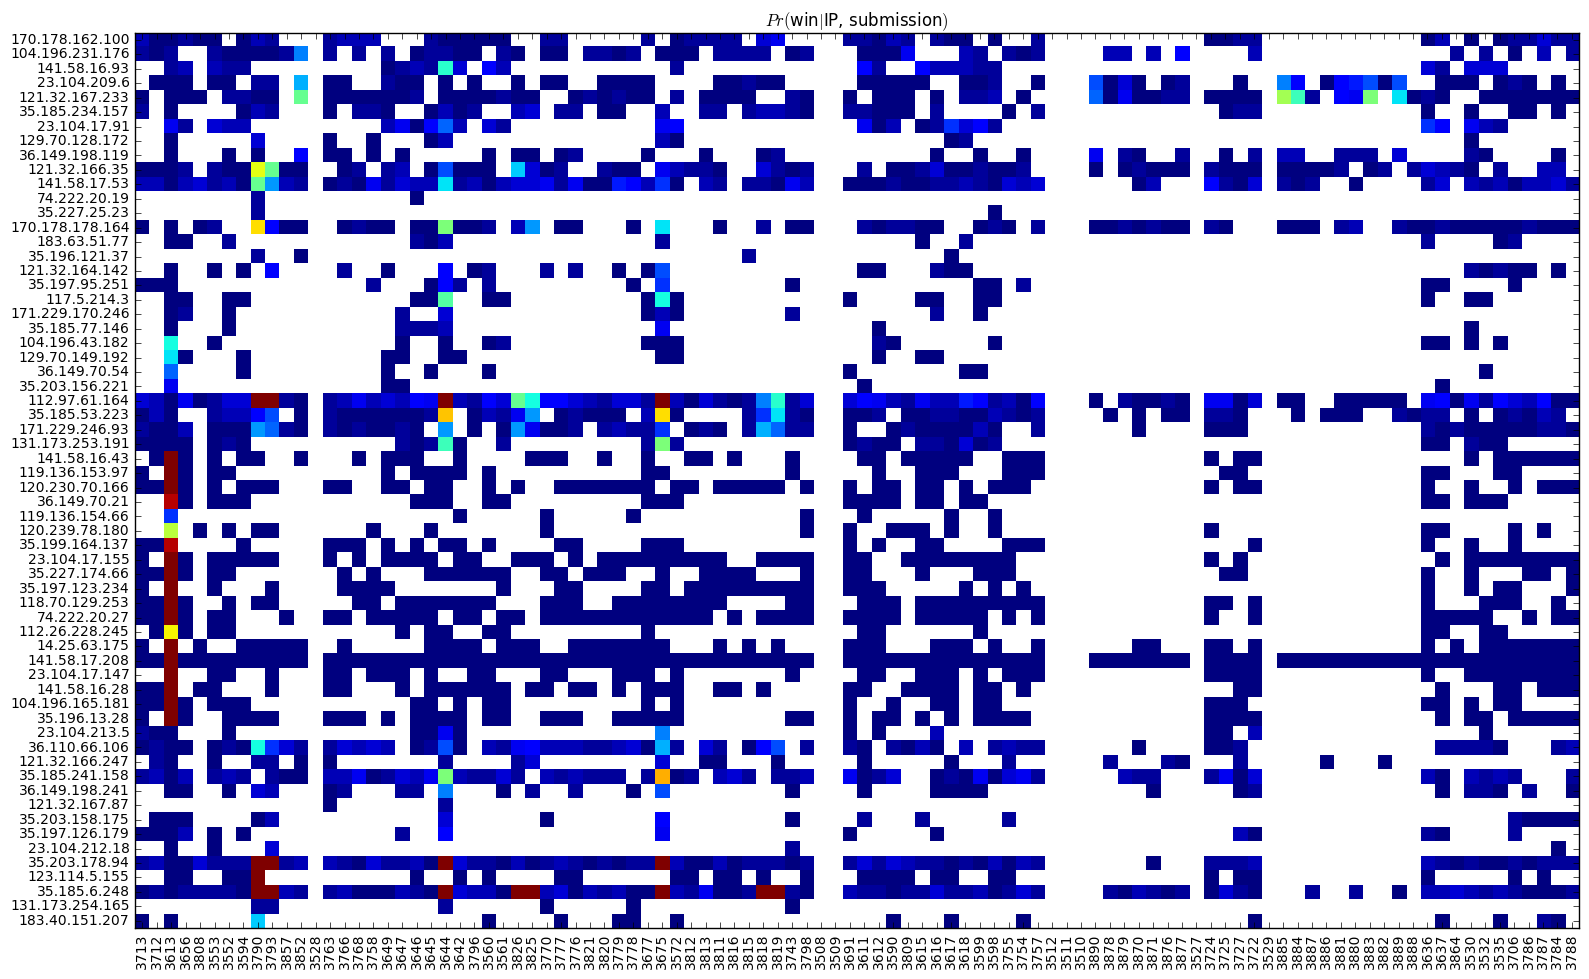

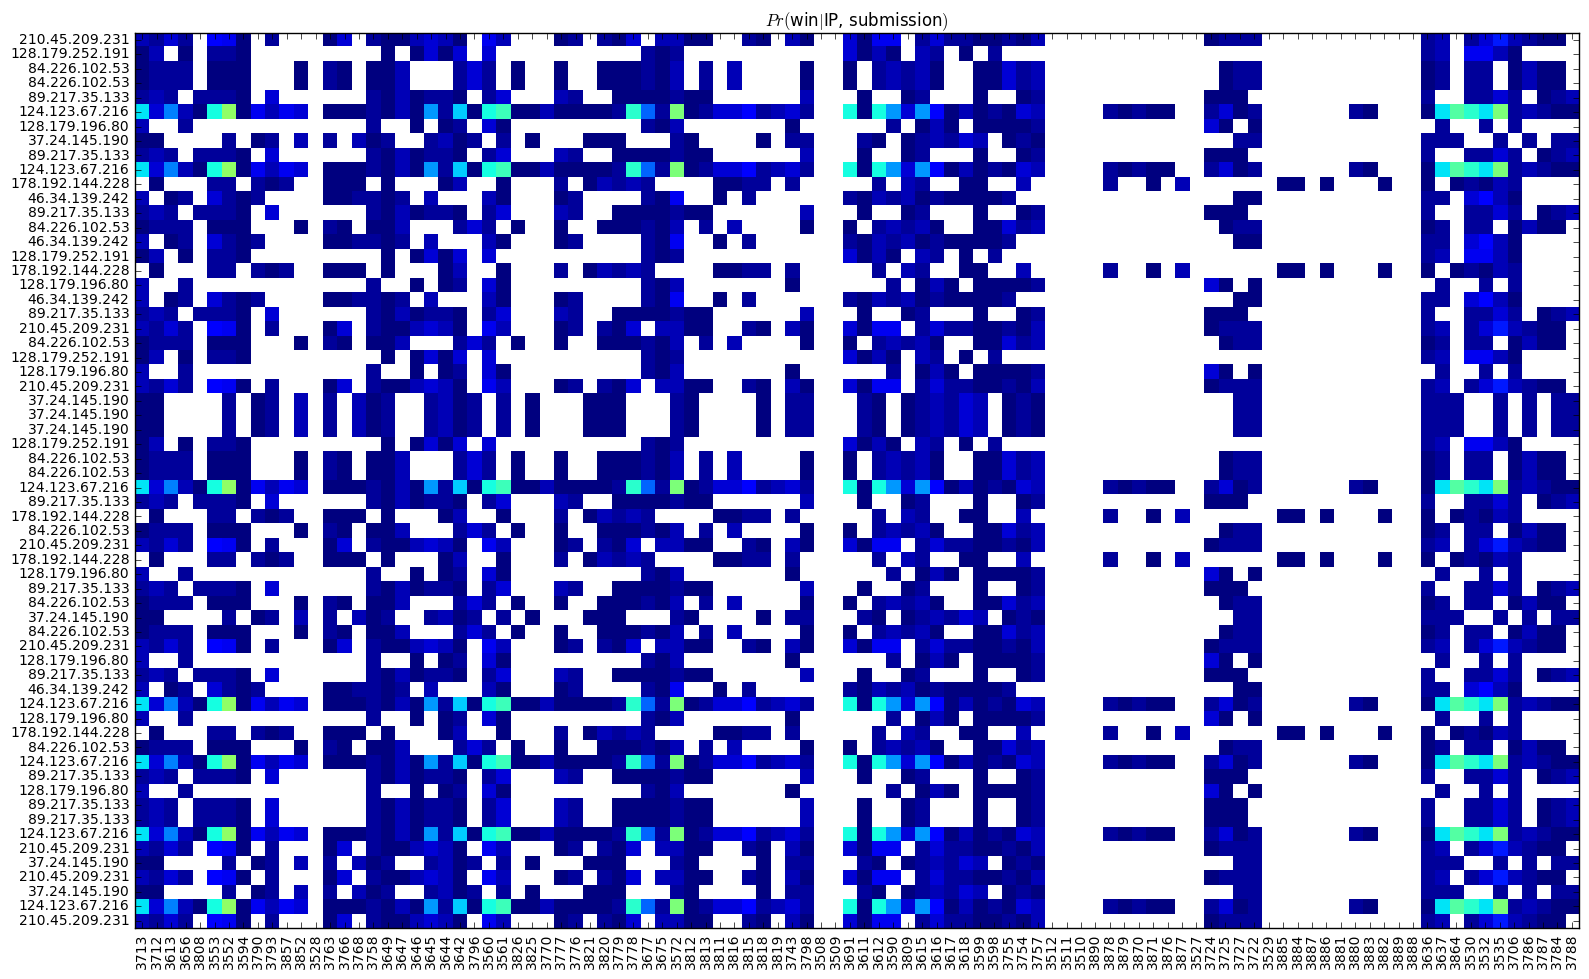

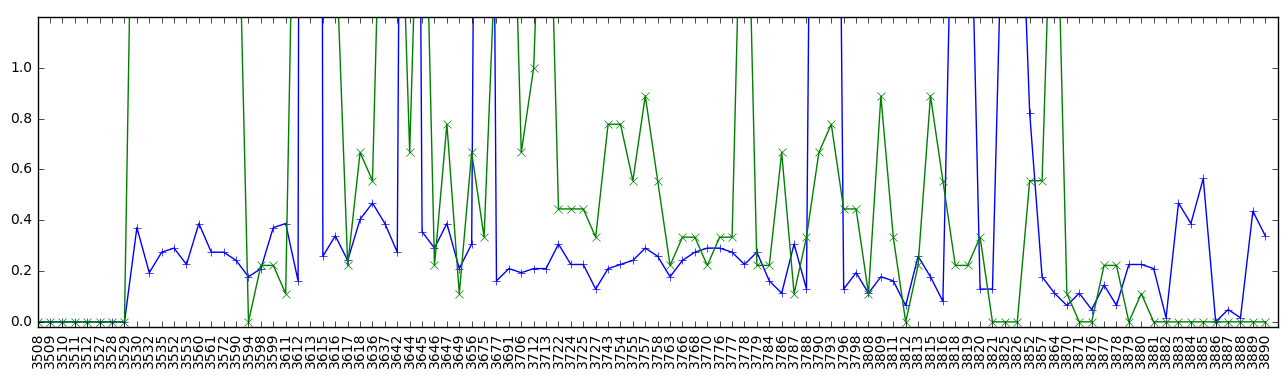

In [85]:
thres = 0.95
mat3 = []
mat32 = []
cheaters3 = []
cheatersIPs3 = []
matcontrol3 = []
matcontrol3all = []
matcontrol32 = []
IPcontrol3 = []
cities = []
controlcities = []
idx = 0
for key, val in logperaddr.items():
    idx += 1
    hist = {}
    for subid in submission_ids:
        hist[subid] = []
    for l in val:
        for subid in submission_ids:
            if l['submission_1'] == subid:
                if l['winner'] == 0:
                    hist[subid].append(1)
                else:
                    hist[subid].append(0)
            elif l['submission_2'] == subid:
                if l['winner'] == 1:
                    hist[subid].append(1)
                else:
                    hist[subid].append(0)          
    cheat = False
    suspect = False
    canbecontrol = True
    cheater_ids = []
    tag = ''
    tmp = [len(v) for _,v in hist.items() if len(v) > 0]
    std = np.std(tmp)
    mean = np.mean(tmp)
    if std < 1.:
        std = 1.
    criticsubmissionnumber = mean + 2*std
    for k,v in hist.items():
        hist[k] = (np.mean(hist[k]), hist[k])
        if hist[k][0] > thres and k not in controls:
            if len(hist[k][1]) >= criticsubmissionnumber:
                suspect = True
                cheater_ids.append(k)
            
    vec2 = [v[0]*len(v[1]) for _, v in hist.items()]
    vec = [v[0] for _, v in hist.items()]
    
    if suspect:
        tag += '[SUSPECT]'
        
    if key in invalidIPs:
        mat3.append(vec)
        mat32.append(vec2)
        tag += '->[CHEAT]'
        cheatersIPs3.append(key)
        cheaters3.extend(cheater_ids)
        cities.append(GEOIP.record_by_addr(key)['city'])
    if tag =='':
        
        matcontrol3all.append(vec)
        if len(val) > 20:
            controlcities.append(GEOIP.record_by_addr(key)['city'])
            matcontrol3.append(vec)
            matcontrol32.append(vec2)
            IPcontrol3.append(key)
            
    print
    print idx, tag, key, GEOIP.record_by_addr(key)['city'],  GEOIP.record_by_addr(key)['country_code'], cheater_ids, np.sum([len(hist[id][1]) for id in cheater_ids]), criticsubmissionnumber
    for k,v in hist.items():
        if len(v[1]) > 0:
            if k in controls:
                print 'CONTROL', k, v
            else:
                print k, v

cheaters3 = sorted(set(cheaters3))
print cheaters3

vmax = 1
sortidxes = np.argsort(cities)
mat3 = np.asarray(mat3)[sortidxes]
plt.figure(figsize=(16,16))
plt.title('$Pr($win$|$IP, submission$)$')
plt.imshow(np.asarray(mat3), interpolation='nearest', vmax=vmax)
xlabels = []
for k,v in hist.items():
    xlabels.append(k)
plt.xticks(range(len(xlabels)), xlabels, rotation='vertical')
plt.yticks(range(len(cheatersIPs3)), cheatersIPs3, rotation='horizontal')
plt.tight_layout()
#plt.colorbar()

sortidxes = np.argsort(controlcities)
matcontrol3 = np.asarray(matcontrol3)[sortidxes]
plt.figure(figsize=(16,16))
plt.title('$Pr($win$|$IP, submission$)$')
idxes = np.random.randint(len(matcontrol3),size=len(cheatersIPs3))
plt.imshow(np.asarray(matcontrol3)[idxes], interpolation='nearest', vmax=vmax)
xlabels = []
for k,v in hist.items():
    xlabels.append(k)
plt.yticks(range(len(cheatersIPs3)), np.asarray(IPcontrol3)[idxes], rotation='horizontal')
plt.xticks(range(len(xlabels)), xlabels, rotation='vertical')
plt.tight_layout()
#plt.colorbar()

vmax = 40
sortidxes = np.argsort(cities)
mat32 = np.asarray(mat32)[sortidxes]
plt.figure(figsize=(16,16))
plt.title('$Pr($win$|$IP, submission$)$')
plt.imshow(np.asarray(mat32), interpolation='nearest', vmax=vmax)
xlabels = []
for k,v in hist.items():
    xlabels.append(k)
plt.xticks(range(len(xlabels)), xlabels, rotation='vertical')
plt.yticks(range(len(cheatersIPs3)), cheatersIPs3, rotation='horizontal')
plt.tight_layout()
#plt.colorbar()

sortidxes = np.argsort(controlcities)
matcontrol32 = np.asarray(matcontrol32)[sortidxes]
plt.figure(figsize=(16,16))
plt.title('$Pr($win$|$IP, submission$)$')
idxes = np.random.randint(len(matcontrol3),size=len(cheatersIPs3))
plt.imshow(np.asarray(matcontrol32)[idxes], interpolation='nearest', vmax=vmax)
xlabels = []
for k,v in hist.items():
    xlabels.append(k)
plt.yticks(range(len(cheatersIPs3)), np.asarray(IPcontrol3)[idxes], rotation='horizontal')
plt.xticks(range(len(xlabels)), xlabels, rotation='vertical')
plt.tight_layout()
#plt.colorbar()

thres = 0.6
plt.figure(figsize=(16,4))
shuffle = np.argsort(xlabels)
x = np.nansum(np.asarray(mat32),axis=0)/len(mat32)
c = np.nansum(np.asarray(matcontrol32),axis=0)/len(matcontrol32)
plt.plot(x[shuffle], '-+')
plt.plot(c[shuffle], '-x')
plt.ylim([-0.02, 2*thres])
plt.xticks(range(len(xlabels)), [xlabels[i] for i in shuffle], rotation='vertical')
suspects = np.asarray(xlabels)[np.where(x > thres)]


# Check distribution of IP addresses

In [88]:
print "##################CHEAT IPs##################"
loc = []
for IP in invalidIPs:
    loc.append((GEOIP.record_by_addr(IP)['country_code'], GEOIP.record_by_addr(IP)['city']))
loccheat = set(sorted(loc))
for l in loccheat:
    print l

##################CHEAT IPs##################
('CN', u'Shenzhen')
('CN', u'Guangzhou')
('US', u'Las Vegas')
('VN', u'Hanoi')
('CN', u'Suzhou')
('US', u'Phoenix')
('CN', u'Wuhu')
('DE', None)
('CN', u'Beijing')
('US', u'Mountain View')
('CN', u'Zhangjiagang')
('US', u'Los Angeles')


In [89]:
print "##################CONTROL##################"
loc = []
for IP, _ in logperaddr.items():
    if IP not in cheatersIPs3:
        loc.append((GEOIP.record_by_addr(IP)['country_code'], GEOIP.record_by_addr(IP)['city']))
loc = set(sorted(loc))
for l in loc:
    print l

##################CONTROL##################
('US', u'Ithaca')
('CN', u'Shanghai')
('IN', u'Delhi')
('CH', u'Aigle')
('US', u'Wilmington')
('KR', u'Busan')
('IN', u'Faridabad')
('IN', u'Kharagpur')
('JP', u'Osaka')
('CH', u'Fribourg')
('PT', u'Id\xe3es')
('CH', u'Sedeilles')
('IN', u'Attapur')
('FR', u'Paris')
('CH', u'Dompierre')
('FR', u'Lyon')
('US', u'Bonham')
('CA', u'Toronto')
('US', u'Winthrop')
('GB', u'Reading')
('HR', None)
('FR', u'Charenton-le-pont')
('FR', u'Saint-leu')
('US', u'Sunnyvale')
('FR', u'Vaulry')
('CH', u'Vufflens-le-chateau')
('CH', u'Crissier')
('CH', u'Bussigny')
('US', u'Stanford')
('CH', u'Ecublens')
('PL', u'Warsaw')
('CA', u'Saint-polycarpe')
('RU', u'Krasnodar')
('CH', u'Schattdorf')
('PL', None)
('US', u'Santa Maria')
('GR', None)
('CH', u'Lausanne')
('FI', u'Tampere')
('RU', u'Zheleznodorozhny')
('CH', u'Emmen')
('NL', None)
('US', u'San Mateo')
('RU', u'Cheboksary')
('CH', u'Schoftland')
('SA', u'Jeddah')
('NC', None)
('FR', u'Aix-en-provence')
('RU',

In [90]:
cities = [l[1] for l in loc]
cheatcities = []
for l in loccheat:
    if l[1] not in cities:
        print l
        cheatcities.append(l[1])

('US', u'Las Vegas')
('VN', u'Hanoi')
('CN', u'Suzhou')
('US', u'Phoenix')
('CN', u'Wuhu')
('US', u'Mountain View')
('CN', u'Zhangjiagang')


# Create the filtered log

In [91]:
#Filter out LOG
FilteredLog = []
for l in log:
    if l['remote_addr'] in invalidIPs:
        continue
    else:
        FilteredLog.append(l)
print len(log), len(FilteredLog)

f = open('META/FILTERED_LOGS.pkl', 'wb')
cPickle.dump(FilteredLog, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()


6900 1758


# Compute scores

In [92]:
logs = cPickle.load(open("meta/FILTERED_LOGS.pkl"))
scores = {}

for _idx, _log in enumerate(logs):

    sub_1 = int(_log['submission_1'])
    sub_2 = int(_log['submission_2'])

    winner = _log['winner']

    try:
        score_1 = scores[sub_1]
    except:
        score_1 = trueskill.Rating()

    try:
        score_2 = scores[sub_2]
    except:
        score_2 = trueskill.Rating()

    if winner == 0:
        n_score_1, n_score_2 = trueskill.rate_1vs1(
            score_1,
            score_2
        )
    else:
        n_score_2, n_score_1 = trueskill.rate_1vs1(
            score_2,
            score_1
        )

    scores[sub_1] = n_score_1
    scores[sub_2] = n_score_2

    #print _idx



env = trueskill.global_env()


output = open("new_scores.csv","w")
output.write("submission_id, score, mu, sigma\n")
for _idx, _key in enumerate(scores):
    output.write("{}, {}, {}, {}\n".format(_key, env.expose(scores[_key]), scores[_key].mu, scores[_key].sigma))
    #print "Writing : ",_idx

output.close()
print("submission_id, score, mu, sigma\n")
for _idx, _key in enumerate(scores):
    print("{}, {}, {}, {}".format(_key, env.expose(scores[_key]), scores[_key].mu, scores[_key].sigma))

submission_id, score, mu, sigma

3590, 27.3749213234, 30.8680890488, 1.16438924182
3594, 10.0688288618, 16.418545971, 2.11657236974
3598, 14.5716809009, 19.4460396232, 1.62478624077
3599, 10.9778072078, 15.9347016087, 1.65229813361
3611, 21.1581110438, 24.7652273291, 1.2023720951
3612, 26.5252804562, 29.9051739347, 1.12663115952
3613, 21.7487727071, 24.729603329, 0.993610207298
3615, 26.9294981823, 30.5024322052, 1.19097800763
3616, 22.3269150935, 25.5401710536, 1.07108532006
3617, 11.6738295749, 17.655059901, 1.99374344203
3618, 18.9697765802, 23.0540673782, 1.36143026598
3636, 18.2341494652, 22.917150685, 1.5610004066
3637, 26.9571749395, 30.6831296715, 1.24198491067
3642, 26.9586359279, 30.803481635, 1.28161523572
3644, 20.9352667769, 24.6225811402, 1.2291047878
3645, 26.106740994, 29.6961766184, 1.19647854146
3646, 16.35950529, 21.3712249853, 1.67057323178
3647, 20.7093215981, 24.9154765875, 1.40205166312
3649, 16.2075988948, 21.354944189, 1.71578176475
3656, 19.7723625212, 24.1236